In [66]:
import numpy as np
import pandas as pd
import os
import pickle as pkl
import time
import matplotlib.pyplot as plt

In [8]:
path_data = os.path.join(os.getcwd(), "data")
path_scenario = os.path.join(os.getcwd(), "scenario")

In [9]:

path_cash = os.path.join(path_data, "C3M Historical Data.csv")
path_GVT_EU13 = os.path.join(path_data, "CSBGE3 Historical Data.csv")
path_EM = os.path.join(path_data, "EMKT Historical Data.csv")
path_GVT_EU57 = os.path.join(path_data, "X57E Historical Data.csv")
path_EQ_EU = os.path.join(path_data, "XESC Historical Data.csv")
path_EQ_US = os.path.join(path_data, "IUSEA Historical Data.csv")

In [6]:
def data_cleaning(dataset, nameETF):
    dataset["Date"] = pd.to_datetime(dataset.Date)
    # Sorting on Ascending Date
    dataset = dataset.sort_values("Date", ignore_index = True)
    # Correction for 0 Prices
    dataset.Price.replace(0, np.NaN, inplace = True)
    dataset.fillna(method="bfill", inplace = True)
    clean_dataset = pd.DataFrame()
    # Compute Exp return (Note: first Date useless)
    clean_dataset["Date"] = dataset.Date[:-1]
    clean_dataset[nameETF] = np.log(dataset.Price[1:].array/dataset.Price[:-1].array)
    return clean_dataset

raw_cash = pd.read_csv(path_cash)
cash = data_cleaning(raw_cash, "Cash")

raw_GVT_EU13 = pd.read_csv(path_GVT_EU13)
GVT_EU13 = data_cleaning(raw_GVT_EU13, "GVT_EU13")

raw_GVT_EU57 = pd.read_csv(path_GVT_EU57)
GVT_EU57 = data_cleaning(raw_GVT_EU57, "GVT_EU57")

raw_EM = pd.read_csv(path_EM)
EM = data_cleaning(raw_EM, "EM")

raw_EQ_EU = pd.read_csv(path_EQ_EU)
EQ_EU = data_cleaning(raw_EQ_EU, "EQ_EU")

raw_EQ_US = pd.read_csv(path_EQ_US)
EQ_US = data_cleaning(raw_EQ_US, "EQ_US")


In [7]:
ETF_HS = pd.DataFrame()
ETF_HS["Date"] = pd.date_range("1/1/2011", "31/12/2020")
ETF_HS = ETF_HS.merge(cash, how = "outer")
ETF_HS = ETF_HS.merge(GVT_EU13, how = "outer")
ETF_HS = ETF_HS.merge(GVT_EU57, how = "outer")
ETF_HS = ETF_HS.merge(EM, how = "outer")
ETF_HS = ETF_HS.merge(EQ_EU, how = "outer")
ETF_HS = ETF_HS.merge(EQ_US, how = "outer")
ETF_HS = ETF_HS.sort_values("Date", ignore_index = True)
ETF_HS.fillna(0, inplace = True)
ETF_HS.set_index("Date", inplace = True)
#ETF_HS.head()

In [8]:
# Resample ETF HS from daily to weekly
ETF_HS_W = ETF_HS.resample("W").sum()
# First entry useless (all 0 records)
ETF_HS_W = ETF_HS_W.iloc[ETF_HS_W.index>np.datetime64("2011-01-02")]
#ETF_HS_W.head()

In [9]:
P = list(ETF_HS.columns)
ETF_HS_W.describe().loc[["mean", "50%", "std"],P]*np.array([[52],[52],[np.sqrt(52)]])

,Cash,GVT_EU13,GVT_EU57,EM,EQ_EU,EQ_US
mean,-0.001423,0.009570,0.038129,0.031010,0.055719,0.107007
50%,-0.004301,0.004739,0.049907,0.124795,0.188141,0.167480
std,0.001700,0.013288,0.035018,0.207708,0.212798,0.167990


In [10]:
ETF_HS_W[P].corr()

,Cash,GVT_EU13,GVT_EU57,EM,EQ_EU,EQ_US
Cash,1.000000,0.385334,0.325676,0.045647,0.078905,0.038291
GVT_EU13,0.385334,1.000000,0.704937,0.126925,0.242598,0.130469
GVT_EU57,0.325676,0.704937,1.000000,0.152114,0.225065,0.093100
EM,0.045647,0.126925,0.152114,1.000000,0.732737,0.697830
EQ_EU,0.078905,0.242598,0.225065,0.732737,1.000000,0.783541
EQ_US,0.038291,0.130469,0.093100,0.697830,0.783541,1.000000


In [11]:
# mean - sigma definition for Geometric Brownian Motion
#mean_GBM = ETF_HS_W.describe().loc["50%"].values # 50% percentile may be more consistent than mean.
#mean_GBM = ETF_HS_W.describe().loc["mean"].values
mean_GBM = np.array([-0.001, 0.005, 0.015, 0.060, 0.070, 0.055 ])/52
sigma_GBM = ETF_HS_W.cov()

col_GBM = ["Date", "Simulation", "Cash", "GVT_EU13", "GVT_EU57", "EM", "EQ_EU", "EQ_US"]
ETF_GBM = pd.DataFrame(columns = col_GBM)
P = list(ETF_GBM.drop(["Date", "Simulation"], axis = 1).columns)
# Return scenarios number
n_sim = 1000

# projection_range: 50 years by month, starting from weekly exp-return sampling
projection_range = pd.date_range("1/1/2021", "31/12/2070", freq = "W")

for iteration in np.arange(n_sim):
    # sample exp-return
    simulated_return = np.random.multivariate_normal(mean = mean_GBM, cov = sigma_GBM, size = projection_range.shape)
    # Save sampled exp-return 
    iter_simul_W = pd.DataFrame(simulated_return, columns = ETF_GBM.drop(["Date","Simulation"], axis = 1).columns)
    iter_simul_W["Date"] = projection_range
    # Swap frequency from weekly to monthly
    iter_simul_M = iter_simul_W.set_index("Date").resample("M").sum()
    # Append last simulation to general scearios dataframe
    iter_simul_M.insert(2, "Simulation", pd.to_numeric(np.ones(iter_simul_M.shape[0])*iteration))
    ETF_GBM = ETF_GBM.append(iter_simul_M.reset_index(), ignore_index = True)

ETF_GBM[P] = ETF_GBM[P] - ETF_GBM[P].mean() + mean_GBM*52/12  
ETF_GBM["Simulation"] = ETF_GBM["Simulation"].astype("int32")

#ETF_GBM.head()

In [12]:
# Save scenarios dataframe
filename = os.path.join(path_scenario, "ETF_GBM.pkl")
fileopen = open(filename, "wb")
pkl.dump(ETF_GBM, fileopen)
fileopen.close()

In [13]:
tic = time.time()
# Scenario
N = ETF_GBM.Simulation.unique()
Scenario = {}
Simulation = ETF_GBM.Simulation
Date = ETF_GBM.Date
Scenario_df = ETF_GBM
for p in P:
    Scenario[p] = {} 
    for n in N:
        Scenario[p][n] = Scenario_df.loc[Simulation == n, p].array
toc = time.time()
print(f"Elapsed in {np.round(toc-tic,2)}s" )

Elapsed in 3.95s


In [14]:
# Save scenarios dataframe
filename = os.path.join(path_scenario, "Scenario.pkl")
fileopen = open(filename, "wb")
pkl.dump(Scenario, fileopen)
fileopen.close()

In [15]:
Scenario_corr = ETF_GBM[P].corr()
Scenario_mu = ETF_GBM[P].mean()
Scenario_sigma = ETF_GBM[P].cov()

In [16]:
Scenario_mu["Cash"]

-8.333333333333336e-05

In [17]:
user_portfolio = {"Cash":0, "GVT_EU13":0.25, "GVT_EU57":0.25, "EM":0.10, "EQ_EU":0.20, "EQ_US":0.20}
portfolio = pd.Series(user_portfolio.values(), index = user_portfolio.keys())
print(Scenario_sigma)
print(np.sqrt(np.sum((Scenario_sigma * portfolio).T.sum().T*portfolio)))

np.sqrt(np.dot(np.dot(portfolio,Scenario_sigma),portfolio))


                  Cash      GVT_EU13  GVT_EU57        EM     EQ_EU  \
Cash      2.418354e-07  7.277352e-07  0.000002  0.000001  0.000002   
GVT_EU13  7.277352e-07  1.476381e-05  0.000027  0.000030  0.000058   
GVT_EU57  1.624054e-06  2.743616e-05  0.000103  0.000094  0.000142   
EM        1.358790e-06  2.966139e-05  0.000094  0.003613  0.002713   
EQ_EU     2.392912e-06  5.763903e-05  0.000142  0.002713  0.003792   
EQ_US     8.924062e-07  2.458846e-05  0.000047  0.002038  0.002344   

                 EQ_US  
Cash      8.924062e-07  
GVT_EU13  2.458846e-05  
GVT_EU57  4.680417e-05  
EM        2.038155e-03  
EQ_EU     2.344174e-03  
EQ_US     2.358195e-03  
0.026528580466804536


0.026528580466804536

In [18]:
# Save scenarios propriety
filename = os.path.join(path_scenario, "Scenario_corr.pkl")
fileopen = open(filename, "wb")
pkl.dump(Scenario_corr, fileopen)
fileopen.close()

filename = os.path.join(path_scenario, "Scenario_mu.pkl")
fileopen = open(filename, "wb")
pkl.dump(Scenario_mu, fileopen)
fileopen.close()

filename = os.path.join(path_scenario, "Scenario_sigma.pkl")
fileopen = open(filename, "wb")
pkl.dump(Scenario_sigma, fileopen)
fileopen.close()

# Visual Analysis

In [10]:
scenarios = open( os.path.join(path_scenario, "ETF_GBM.pkl"), "rb")
GBM_analysis = pkl.load(scenarios)
scenarios.close()


In [11]:
P = list(GBM_analysis.drop(["Date", "Simulation"], axis = 1).columns)
GBM_analysis.describe().loc[["mean", "50%", "std"],P]*np.array([[12],[12],[np.sqrt(12)]])

,Cash,GVT_EU13,GVT_EU57,EM,EQ_EU,EQ_US
mean,-0.001000,0.005000,0.015000,0.060000,0.070000,0.055000
50%,-0.000993,0.005013,0.014981,0.059557,0.069743,0.054503
std,0.001704,0.013310,0.035104,0.208221,0.213303,0.168221


In [12]:
GBM_analysis[P].corr()

,Cash,GVT_EU13,GVT_EU57,EM,EQ_EU,EQ_US
Cash,1.000000,0.385136,0.325894,0.045968,0.079024,0.037369
GVT_EU13,0.385136,1.000000,0.704628,0.128428,0.243619,0.131778
GVT_EU57,0.325894,0.704628,1.000000,0.154823,0.227636,0.095111
EM,0.045968,0.128428,0.154823,1.000000,0.732951,0.698254
EQ_EU,0.079024,0.243619,0.227636,0.732951,1.000000,0.783959
EQ_US,0.037369,0.131778,0.095111,0.698254,0.783959,1.000000


In [13]:
N = GBM_analysis.Simulation.unique()
P = GBM_analysis.drop(["Date", "Simulation"], axis = 1).columns
Cum_return = pd.DataFrame(columns = GBM_analysis.columns)
Date = GBM_analysis.Date.unique()
for n in N:
    Cum_return_n = pd.DataFrame(np.cumsum(GBM_analysis.loc[GBM_analysis.Simulation==n, P].to_numpy(), axis=0),columns = P)
    Cum_return_n["Simulation"] = n
    Cum_return_n["Date"] = Date
    Cum_return = Cum_return.append(Cum_return_n)

perc_95 = Cum_return.groupby("Date").quantile(0.95)
perc_50 = Cum_return.groupby("Date").quantile(0.50)
perc_05 = Cum_return.groupby("Date").quantile(0.05)


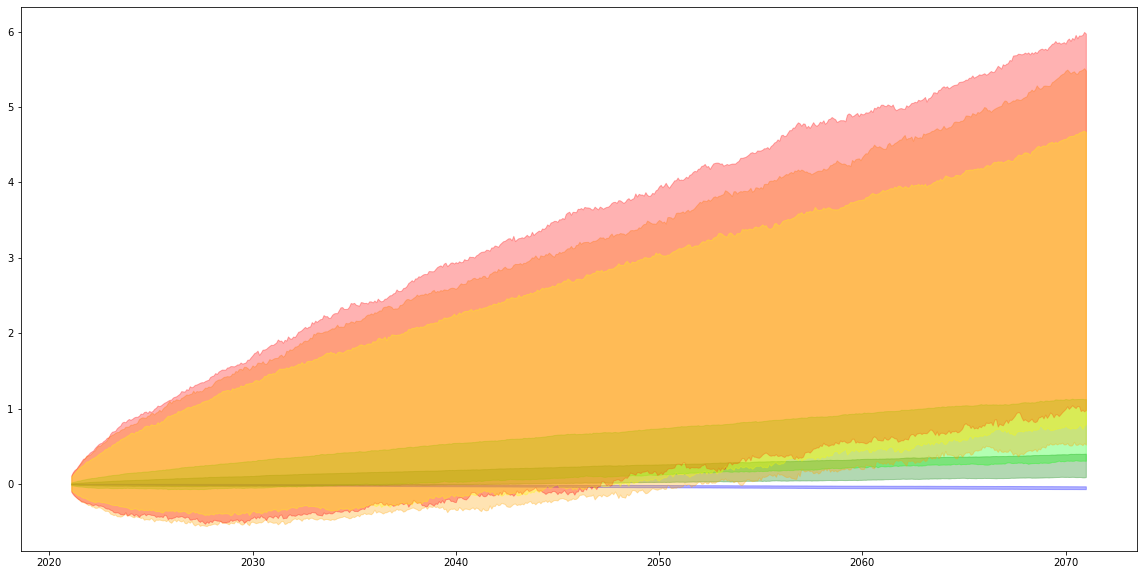

In [65]:
colormap = {P[0]:"blue", P[1]:"green", P[2]:"lime", P[3]:"orange", P[4]:"red", P[5]:"yellow"}
plt.figure(figsize=(20,10))
for p in P:
    plt.fill_between(perc_95.loc[perc_95.index < np.datetime64("2071-01-01")].index,perc_95.loc[perc_95.index < np.datetime64("2071-01-01"), p].to_numpy(),perc_05.loc[perc_05.index < np.datetime64("2071-01-01"), p].to_numpy(),alpha = 0.3, color = colormap[p])
plt.show()

# MV Efficient Frontier

In [40]:
# Calculate annualized average return for each stock. Annualized average return = Daily average return * 252 business days.
scenarios = open( os.path.join(path_scenario, "Scenario_mu.pkl"), "rb")
r = pkl.load(scenarios)
r = r.values
scenarios.close()

# Create a covariance matrix
scenarios = open( os.path.join(path_scenario, "Scenario_sigma.pkl"), "rb")
covar = pkl.load(scenarios)
covar = covar.values
scenarios.close()

In [41]:
#Define frequently used functions.
# r is each stock's return, w is the portion of each stock in our portfolio, and covar is the covariance matrix
# Rate of return
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
def sharpe (ret,vol):
    return ret/vol

In [42]:
# All weights, of course, must be between 0 and 1. Thus we set 0 and 1 as the boundaries.
from scipy.optimize import Bounds
bounds = Bounds(0, 1)

# The second boundary is the sum of weights.
from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint(np.ones((GBM_analysis[P].shape[1],), dtype=int),1,1)

# Find a portfolio with the minimum risk.
from scipy.optimize import minimize
#Create x0, the first guess at the values of each stock's weight.
weights = np.ones(GBM_analysis[P].shape[1])
x0 = weights/np.sum(weights)
#Define a function to calculate volatility
fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

np.set_printoptions(suppress = True, precision=2)
print(w_min)
print('return: % .2f'% (ret(r,w_min)*100), 'risk: % .3f'% vol(w_min,covar))

[1. 0. 0. 0. 0. 0.]
return: -0.01 risk:  0.000


In [43]:
#Define 1/Sharpe_ratio
fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
w_sharpe = res_sharpe.x
print(w_sharpe)
print('return: % .2f'% (ret(r,w_sharpe)*100), 'risk: % .3f'% vol(w_sharpe,covar))

[0.   0.45 0.46 0.01 0.   0.08]
return:  0.12 risk:  0.008


In [80]:
w = w_min
num_ports = 100
gap = (np.amax(r) - ret(r,w_min))/num_ports


all_weights = np.zeros((num_ports, len(GBM_analysis[P].columns)))
all_weights[0],all_weights[1]=w_min,w_sharpe
ret_arr = np.zeros(num_ports)
ret_arr[0],ret_arr[1]=ret(r,w_min),ret(r,w_sharpe)
vol_arr = np.zeros(num_ports)
vol_arr[0],vol_arr[1]=vol(w_min,covar),vol(w_sharpe,covar)

for i in range(num_ports):
    port_ret = ret(r,w) + i*gap
    double_constraint = LinearConstraint([np.ones(GBM_analysis[P].shape[1]),r],[1,port_ret],[1,port_ret])
    
    #Create x0: initial guesses for weights.
    x0 = w_min
    #Define a function for portfolio volatility.
    fun = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
    a = minimize(fun,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)
    
    all_weights[i,:]=a.x
    ret_arr[i]=port_ret
    vol_arr[i]=vol(a.x,covar)
    
sharpe_arr = ret_arr/vol_arr  

eff_front = pd.DataFrame(all_weights, columns = P)

In [68]:
n_dots = 10000
alfa = np.zeros(shape = P.shape) + 0.2
ret_p = np.zeros(n_dots)
vol_p = np.zeros(n_dots)
port = np.random.dirichlet(alfa, n_dots)
for i in np.arange(n_dots):
    ret_p[i] = ret(r,port[i,:])
    vol_p[i] = vol(port[i,:], covar)

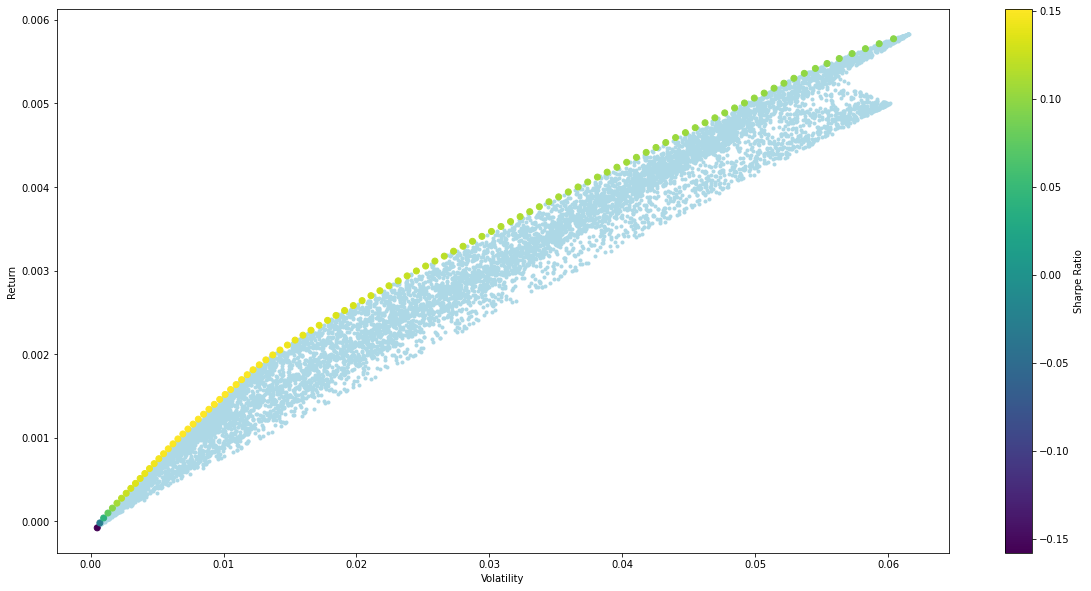

In [107]:
plt.figure(figsize=(20,10))
plt.scatter(vol_p, ret_p, marker = ".", c = "lightblue")
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [111]:
eff_front["ret_Y"] = ret_arr*12
eff_front["vol_Y"] = vol_arr*np.sqrt(12)

eff_front

,Cash,GVT_EU13,GVT_EU57,EM,EQ_EU,EQ_US,ret_Y,vol_Y
0,0.996520,0.002362,0.000613,0.000171,0.000141,0.000193,-0.000945,0.001725
1,0.938780,0.044262,0.011929,0.001484,0.001279,0.002267,-0.000235,0.002413
2,0.877215,0.085217,0.028778,0.001589,0.000144,0.007058,0.000474,0.003404
3,0.815380,0.127637,0.044644,0.001992,0.000167,0.010180,0.001184,0.004520
4,0.753534,0.170324,0.060237,0.002625,0.000231,0.013049,0.001893,0.005682
...,...,...,...,...,...,...,...,...
95,0.000008,0.000010,0.000005,0.101116,0.729885,0.168976,0.066453,0.195114
96,0.000030,0.000049,0.000074,0.095279,0.779526,0.125043,0.067162,0.198459
97,0.000040,0.000046,0.000041,0.089242,0.828776,0.081855,0.067872,0.201930
98,0.000006,0.000007,0.000011,0.083116,0.877777,0.039083,0.068581,0.205518


In [137]:
# Save scenarios propriety
filename = os.path.join(path_scenario, "eff_front.pkl")
fileopen = open(filename, "wb")
pkl.dump(eff_front[P].T.to_dict(), fileopen)
fileopen.close()

In [1]:
#Test script: find portfolios on eff front with the respect to the bond ratio in portfolio
######
bond_level = 0.10
bond = ["Cash","GVT_EU13","GVT_EU57"]
######
print(np.sum(eff_front[bond], axis = 1)[(np.sum(eff_front[bond], axis = 1) > bond_level*0.90) & (np.sum(eff_front[bond], axis = 1) < bond_level*1.1)])
eff_front.loc[(np.sum(eff_front[bond], axis = 1) > bond_level*0.90) & (np.sum(eff_front[bond], axis = 1) < bond_level*1.1),:]

# #23 per bond 90% eq 10% -> vola 3%
# #37 per bond 80%-75% eq 20%-25% -> vola 5%
# #56 per bond 50% eq 50% -> vola 9.5%
# #74 per bond 20%-25% eq 80%-75% -> vola 14%
# #84 per bond 10% eq 90% -> vola 16%

NameError: name 'np' is not defined

In [2]:
user_portfolio_code = {
    "bond":23,
    "bond-balanced":37,
    "balanced":56,
    "equity-balanced":74,
    "equity":84
    }

In [134]:
buyandhold_portfolios = eff_front.loc[user_portfolio_code.values(), P].reset_index(drop=True).T.to_dict()
# Save buy-and-hold portfolios
filename = os.path.join(path_scenario, "buyandhold_portfolios.pkl")
fileopen = open(filename, "wb")
pkl.dump(buyandhold_portfolios, fileopen)
fileopen.close()